# fastaiを用いた事前学習済み言語モデルのチューニングとスパム分類

このノートブックでは、fastaiを使って、分類器を構築する方法を紹介します。データセットとしては、[SMSスパムコレクションデータセット](https://www.kaggle.com/uciml/sms-spam-collection-dataset#spam.csv)を使います。まず最初に、通常の分類器の構築方法を紹介します。その後、学習データセットを用いて、事前学習済み言語モデルをチューニングする方法を説明します。


## 準備

### パッケージのインストール

In [1]:
!pip install -U fastai==2.5.2 pandas==1.1.5

     |████████████████████████████████| 186 kB 5.3 MB/s 
     |████████████████████████████████| 56 kB 3.6 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


### インポート

In [2]:
import fastai
import pandas as pd
from fastai import *
from fastai.text import *
from fastai.text.all import *

### データセットのダウンロード

In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
!unzip smsspamcollection.zip

--2021-09-13 13:00:09--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z 100%[===================>] 198.65K   983KB/s    in 0.2s    

2021-09-13 13:00:09 (983 KB/s) - ‘smsspamcollection.zip’ saved [203415/203415]

Archive:  smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


### データセットの読み込み

In [4]:
df = pd.read_csv("SMSSpamCollection", sep="\t", header=None, names=["target", "text"])

In [5]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


データセットのクラス分布を表示してみましょう。分布を見ると、おおよそ10%程度がスパムで、残りの90%は非スパムです。したがって、不均衡データの分類問題を解くことになります。

In [6]:
display(df.shape)  # データセットの行数と列数を表示
df["target"].value_counts() / df.shape[0]  # クラス分布を表示

(5572, 2)

ham     0.865937
spam    0.134063
Name: target, dtype: float64

## テキスト分類モデルの学習

これまでに、pandasでデータを読み込むことはできました。次に、fastaiの[TextDataLoaders.from_df](https://docs.fast.ai/text.data.html#TextDataLoaders.from_df)を用いて、分類用にデータフレームを読み込みます。`text_col`と`label_col`でテキストとラベルのカラム名を指定しています。

In [7]:
seed = 2021
data_class = TextDataLoaders.from_df(
    df,
    seed=seed,
    text_col='text',
    label_col='target',
)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


`show_batch`メソッドを使って、読み込んだデータを見てみましょう。

In [8]:
data_class.show_batch()

,text,category
0,"xxbos xxmaj the last thing i ever wanted to do was hurt you . xxmaj and i did n't think it would have . xxmaj you 'd laugh , be embarassed , xxunk the xxunk and keep going . xxmaj but as far as i knew , it was n't even up . xxmaj the fact that you even felt like i would do it to hurt you shows you really do n't know me at all . xxmaj it was xxunk wednesday , but it was n't bad . xxmaj the problem i have with it is you xxup have the time to clean it , but you choose not to . xxmaj you skype , you take pictures , you sleep , you want to go out . i do n't mind a few things here and there , but when you do n't make the bed ,",ham
1,"xxbos xxmaj sad story of a xxmaj man - xxmaj last week was my b'day . xxmaj my xxmaj wife did'nt wish me . xxmaj my xxmaj parents forgot n so did my xxmaj kids . i went to work . xxmaj even my xxmaj colleagues did not wish . xxmaj as i entered my cabin my xxup pa said , '' xxmaj happy xxmaj b'day xxmaj boss ! ! '' . i felt special . xxmaj she askd me 4 lunch . xxmaj after lunch she invited me to her apartment . xxmaj we went there . xxmaj she said , ' ' do u mind if i go into the bedroom for a minute ? '' ' ' ok ' ' , i sed in a sexy mood . xxmaj she came out 5 minuts latr wid a cake … n xxmaj my xxmaj wife , xxmaj my",ham
2,"xxbos a xxmaj boy loved a gal . xxmaj he xxunk bt she did nt mind . xxmaj he xxunk xxunk xxunk , xxmaj bt her frnds xxunk thm . xxmaj again d boy decided 2 xxunk d gal , xxunk time a xxunk was xxunk towards d gal . xxmaj wn it was about 2 hit d girl , d boy ran like hell n saved her . xxmaj she asked ' hw cn u run so fast ? ' d boy replied "" boost is d secret of my energy "" n instantly d girl shouted "" our energy "" n xxmaj xxunk xxunk xxunk xxunk drinking boost xxunk xxmaj moral of d xxunk i hv free msgs : d ; ) : gud ni8",ham
3,"xxbos xxmaj solve d xxmaj case : a xxmaj man xxmaj was xxmaj found xxmaj murdered xxmaj on < decimal > . < # > afternoon . 1,his wife called xxmaj police . 2,police questioned everyone . 3,wife : sir , i was sleeping , when the murder took place . 4.cook : i was cooking . 5.gardener : i was picking vegetables . 6.house - maid : i went 2 d post office . 7.children : xxmaj we went 2 play . 8.neighbour : xxmaj we went 2 a marriage . xxmaj police arrested d murderer xxmaj immediately . xxmaj who 's xxmaj it ? xxmaj reply xxmaj with xxmaj reason , xxmaj if u r xxmaj brilliant .",ham
4,"xxbos xxmaj good evening xxmaj sir , hope you are having a nice day . i wanted to bring it to your notice that i have been late in paying rent for the past few months and have had to pay a $ < # > charge . i felt it would be xxunk of me to xxunk about something you give at great cost to yourself and that 's why i did nt speak up . i however am in a xxunk and wo nt be able to pay the charge this month xxunk my askin well ahead of month 's end . xxmaj can you please help . xxmaj thank you for everything .",ham
5,"xxbos i ca n't keep going through this . xxmaj it was never my xxunk to run you out , but if you choose to do that rather than keep the room clean so * i * do n't have to say no to xxunk , then maybe that 's the best choice . xxmaj yes , i wanted you to be embarassed , so maybe you 'd feel for once how i feel when i have a friend who wants to drop buy and i have to say no , as happened this morning . xxmaj i 've tried everything . i do n't know what else to do .",ham
6,"xxbos xxmaj storming msg : xxmaj wen u lift d phne , u say "" hello "" xxmaj do u knw wt is d real meaning of xxup hello ? ? . . . xxmaj it 's d name of a girl .. ! . . . xxmaj yes .. xxmaj and u knw who is dat girl ? ? "" margaret xxmaj hello "" xxmaj she is d girlfrnd f xxmaj grahmbell who invnted telphone … . . . . moral : one can 4get d name of a person , bt not his girlfrnd … g o o d n i g h t . . .@",ham
7,"xxbos xxmaj storming msg : xxmaj wen u lift d phne , u say "" hello "" xxmaj do u knw wt is d real meaning of xxup hello ? ? . . . xxmaj it 's d name of a girl .. ! . . . xxm

データを見ると、`xxmaj`、`xxbos`、`xxup`などの見慣れぬトークンがあることがわかります。これらのトークンはニューラルネットワーク用の特別なトークンです。`xxbos`は文の始まりを意味します。`xxmaj`は次の単語が大文字で始まることを示し、`xxup`は次の単語がすべて大文字から成ることを示しています。

データを用意できたので、分類器を学習しましょう。
[text_classifier_learner](https://docs.fast.ai/text.learner.html#text_classifier_learner)に引数を渡して呼び出すことで、分類用の学習器（Learner）を作成します。学習器というのは、モデルやデータ、損失関数などが一体となったクラスのことです。第1引数にデータ、第2引数にアーキテクチャを渡します。今回は、[AWD LSTM](https://arxiv.org/abs/1708.02182)を指定しています。その他、デフォルトで`pretrained=True`となっており、事前学習済みモデルが利用可能であれば利用します。


学習器を定義したら、[fine_tune](https://docs.fast.ai/callback.schedule.html#Learner.fine_tune)メソッドを呼び出して、学習をしましょう。以下ではエポック数と学習率を渡しています。それ以外にも、デフォルトで`freeze_epochs=1`が設定されています。`fine_tune`メソッドを使うことで、最初は`freeze_epochs`数分だけ最終層以外を固定して学習し、その後、モデル全体を学習できます。

In [10]:
learn = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.520585,0.117429,0.955117,00:11


epoch,train_loss,valid_loss,accuracy,time
0,0.232960,0.047314,0.978456,00:14
1,0.147409,0.033671,0.987433,00:14
2,0.089685,0.036065,0.987433,00:14
3,0.053341,0.039771,0.985637,00:14


悪くない性能です。`show_results`メソッドを使って、モデルの予測結果を見てみましょう。

In [11]:
learn.show_results()

,text,category,category_
0,xxbos xxmaj for me the love should start with xxunk should feel that i need her every time around xxunk should be the first thing which comes in my xxunk would start the day and end it with xxunk should be there every time i xxunk will be then when my every xxunk has her xxunk life should happen around xxunk life will be xxunk to xxunk would cry for xxunk give all my happiness and take all her xxunk will be ready to fight with anyone for xxunk will be in love when i will be doing the xxunk things for xxunk will be when i do n't have to xxunk anyone that my girl is the most beautiful lady on the whole xxunk will always be xxunk xxunk for xxunk will be when i start up making chicken xxunk and end up xxunk xxunk will be the most,ham,ham
1,"xxbos < # > is fast xxunk . xxmaj so , xxmaj wish u a very xxmaj happy xxmaj new xxmaj year xxmaj happy xxmaj xxunk xxmaj happy xxunk day xxmaj happy xxmaj valentines xxmaj day xxmaj happy xxmaj xxunk xxmaj happy xxmaj xxunk xxmaj happy xxmaj xxunk day xxmaj happy xxmaj may xxmaj day xxmaj happy xxmaj xxunk xxmaj day , xxmaj happy friendship , mother , father , xxunk , xxunk xxmaj day , & & xxup happy xxup birthday 4 xxup u. xxmaj happy xxmaj xxunk xxunk xxmaj happy xxmaj xxunk xxmaj happy xxmaj xxunk xxmaj happy xxmaj christmas < # > xxmaj good xxmaj xxunk xxmaj xxunk , xxmaj xxunk xxmaj nights . xxunk xxup am the first to xxup wishing u xxup all xxup these … your 's xxmaj xxunk",ham,spam
2,"xxbos no , i * did n't * mean to post it . i xxunk it , and like so many other times i 've xxunk stuff to you , i let it sit there . it xxup was what i was feeling at the time . i was angry . xxmaj before i left , i hit send , then stop . xxmaj it was n't there . i checked on my phone when i got to my car . xxmaj it was n't there . xxmaj you said you did n't sleep , you were bored . xxmaj so why would n't xxup that be the time to clean , xxunk xxunk , etc . ? xxmaj at least make the bed ?",ham,ham
3,"xxbos xxmaj solve d xxmaj case : a xxmaj man xxmaj was xxmaj found xxmaj murdered xxmaj on < decimal > . < # > afternoon . 1,his wife called xxmaj police . 2,police questioned everyone . 3,wife : sir , i was sleeping , when the murder took place . 4.cook : i was cooking . 5.gardener : i was picking vegetables . 6.house - maid : i went 2 d post office . 7.children : xxmaj we went 2 play . 8.neighbour : xxmaj we went 2 a marriage . xxmaj police arrested d murderer xxmaj immediately . xxmaj who 's xxmaj it ? xxmaj reply xxmaj with xxmaj reason , xxmaj if u r xxmaj brilliant .",ham,ham
4,"xxbos xxmaj storming msg : xxmaj wen u lift d phne , u say "" hello "" xxmaj do u knw wt is d real meaning of xxup hello ? ? . . . xxmaj it 's d name of a girl .. ! . . . xxmaj yes .. xxmaj and u knw who is dat girl ? ? "" margaret xxmaj hello "" xxmaj she is d girlfrnd f xxmaj grahmbell who invnted telphone … . . . . moral : one can 4get d name of a person , bt not his girlfrnd … g o o d n i g h t . . .@",ham,ham
5,"xxbos xxmaj no i 'm not . i ca n't give you everything you want and need . xxmaj you actually could do better for yourself on yor own -- xxunk got more money than i do . i ca n't get work , i ca n't get a man , i ca n't pay the rent , i ca n't even fill my fucking gas xxunk . yes , i 'm xxunk and xxunk . i did n't even call home for thanksgiving cuz i 'll have to tell them i , m up to nothing .",ham,ham
6,"xxbos xxmaj sir , i have been late in paying rent for the past few months and had to pay a $ < # > charge . i felt it would be xxunk of me to xxunk about something you give at great cost to yourself and that 's why i did nt speak up . i however am in a xxunk and wo nt be able to pay the charge this month xxunk my askin well ahead of month 's end . xxmaj can you please help . xxmaj thanks",ham,ham
7,"xxbos xxmaj rose for red , red for blood , blood for heart , heart for u. xxmaj but u for me … . xxmaj send tis to all ur friends .. xxmaj including me .. xxmaj if u like me .. xxmaj if u get 

## 言語モデルのチューニング

前節で使用した事前学習済みのモデルは、言語モデルと呼ばれています。このモデルは、Wikipediaのテキストを用いて学習されています。この言語モデルをスパム分類の分類器に使うことで良い性能を得られましたが、もう一歩工夫することで、更に良い結果を得られる可能性があります。Wikipediaのテキストとスパムのテキストは若干異なるので、事前学習済みの言語モデルをスパムのデータセットを用いてチューニングし、それを使って分類器を構築するのです。

全体のプロセスは以下の図のようになります。

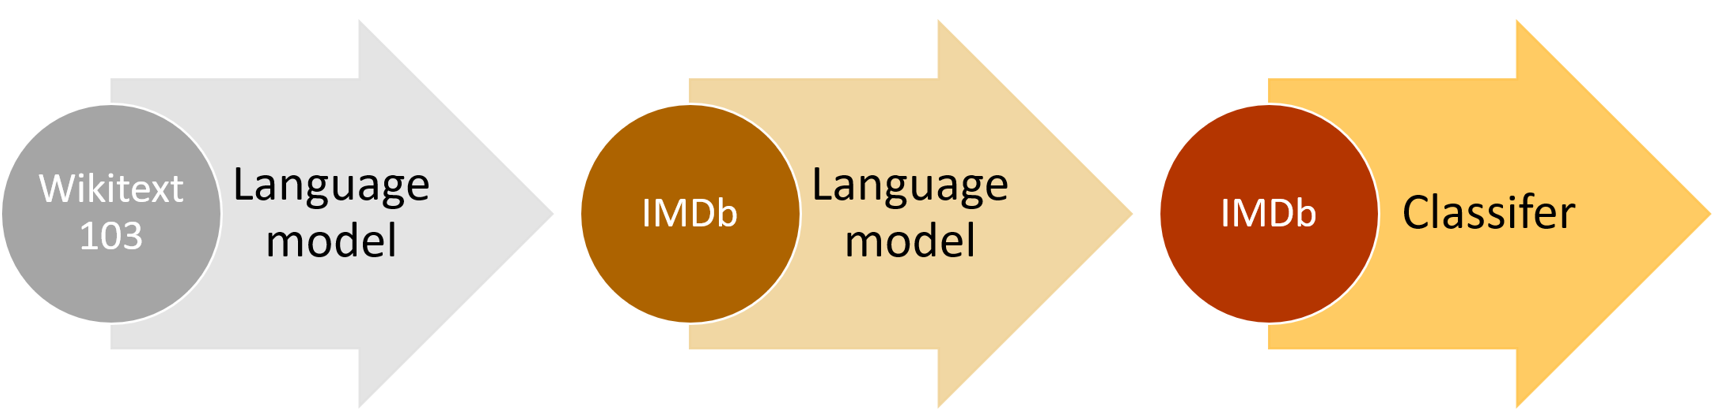

### 言語モデルのチューニング

まずは言語モデルのチューニング用にデータを読み込むことにします。`is_lm=True`を設定することで、言語モデルを学習するためのデータを用意できます。

In [12]:
data_lm = TextDataLoaders.from_df(
    df,
    seed=seed,
    text_col='text',
    is_lm=True
)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [13]:
data_lm.show_batch()

,text,text_
0,xxbos xxmaj much better now thanks lol xxbos xxmaj dear xxunk xxrep 7 x xxmaj u've been invited to xxup xchat . xxmaj this is our final attempt to contact u ! xxmaj txt xxup chat to 86688 150p / msgrcvdhg / xxmaj suite342 / 2lands / xxmaj row / xxup w1j6hl xxup ldn 18yrs xxbos xxmaj yes .. he is really great .. xxunk told kallis best xxunk after xxunk in,xxmaj much better now thanks lol xxbos xxmaj dear xxunk xxrep 7 x xxmaj u've been invited to xxup xchat . xxmaj this is our final attempt to contact u ! xxmaj txt xxup chat to 86688 150p / msgrcvdhg / xxmaj suite342 / 2lands / xxmaj row / xxup w1j6hl xxup ldn 18yrs xxbos xxmaj yes .. he is really great .. xxunk told kallis best xxunk after xxunk in xxunk
1,"xxbos xxmaj talk to g and x about that xxbos xxmaj we can make a baby in yo tho xxbos xxmaj i 'm eatin now lor , but goin back to work soon … e xxunk xxunk show huh … i watch b4 liao , very nice … xxbos xxmaj your daily text from me – a favour this time xxbos xxmaj moji i love you more than words . xxmaj have","xxmaj talk to g and x about that xxbos xxmaj we can make a baby in yo tho xxbos xxmaj i 'm eatin now lor , but goin back to work soon … e xxunk xxunk show huh … i watch b4 liao , very nice … xxbos xxmaj your daily text from me – a favour this time xxbos xxmaj moji i love you more than words . xxmaj have a"
2,"the money but that he 's definitely buying before the end of the week xxbos xxmaj we spend our days waiting for the xxunk xxunk to xxunk in xxunk of us .. xxmaj but what we forget is .. "" xxunk are made by walking .. not by waiting .. "" xxmaj goodnight ! xxbos xxmaj actually i decided i was too hungry so i have n't left yet : v xxbos","money but that he 's definitely buying before the end of the week xxbos xxmaj we spend our days waiting for the xxunk xxunk to xxunk in xxunk of us .. xxmaj but what we forget is .. "" xxunk are made by walking .. not by waiting .. "" xxmaj goodnight ! xxbos xxmaj actually i decided i was too hungry so i have n't left yet : v xxbos xxmaj"
3,".. xxbos xxmaj hey mr what s the name of that bill xxunk book the one about xxunk and words xxbos xxmaj sorry , xxmaj i 'll call later xxbos xxmaj well its not like you actually called someone a xxunk . xxmaj that xxunk been worse . xxbos xxmaj you also did nt get na xxwrep 5 hi xxbos xxmaj xxunk so yummy babe … xxmaj nice xxunk to the xxunk","xxbos xxmaj hey mr what s the name of that bill xxunk book the one about xxunk and words xxbos xxmaj sorry , xxmaj i 'll call later xxbos xxmaj well its not like you actually called someone a xxunk . xxmaj that xxunk been worse . xxbos xxmaj you also did nt get na xxwrep 5 hi xxbos xxmaj xxunk so yummy babe … xxmaj nice xxunk to the xxunk xxbos"
4,"'ll call later in meeting . xxbos xxmaj i 'll pick you up at about xxunk to go to taunton if you still want to come . xxbos i have 2 sleeping bags , 1 xxunk and paper and phone details . xxmaj anything else ? xxbos xxmaj cool , xxmaj i 'll text you in a few xxbos xxmaj she said , ' ' do u mind if i go into","call later in meeting . xxbos xxmaj i 'll pick you up at about xxunk to go to taunton if you still want to come . xxbos i have 2 sleeping bags , 1 xxunk and paper and phone details . xxmaj anything else ? xxbos xxmaj cool , xxmaj i 'll text you in a few xxbos xxmaj she said , ' ' do u mind if i go into the"
5,m8s . xxmaj txt xxmaj tone charity to 8007 for xxmaj nokias or xxmaj poly charity for polys : zed 08701417012 profit 2 charity . xxbos xxmaj finally the match xxunk towards draw as your xxunk . xxbos xxmaj as usual u can call me ard 10 smth . xxbos xxmaj hi .. i got the money da : ) xxbos xxmaj prabha .. i'm soryda .. realy .. frm heart i,. xxmaj txt xxmaj tone charity to 8007 for xxmaj nokias or xxmaj poly charity for polys : zed 08701417012 profit 2 charity . xxbos xxmaj finally the match xxunk towards draw as your xxunk . xxbos xxmaj as usual u can call me ard 10 smth . xxbos xxmaj hi .. i got the money da : ) xxbos xxmaj prabha .. 

次に、用意したデータを用いて、言語モデルをチューニングします。

In [14]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, metrics=[accuracy, Perplexity()], drop_mult=0.5)

Wikipediaで事前学習済みの言語モデルを使って、テキストを生成してみましょう。


In [15]:
for i in range(10):
    print(learn.predict("The food is", n_words=15))

The food is a double fine and a soft food is usually made up of purity - rich


The food is their " drink " , and ate it out to eat . The food


The food is moved from its within , to the back and inside , by food and food


The food is the food source for many of its heard and spoken names . It is


The food is released in South Germany by Ha ' L ' Ran


The food is taken part in fight and is seen as a present - day only touch at


The food is faster than it is available for food and waste and is more expensive . a


The food is family , the food is the food , and the food is the largest food


The food is World 's Best Food Flower Sub - Top


The food is spent on a food source , but some access of the food has been taken


では、言語モデルのチューニングをします。

In [16]:
learn.fine_tune(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.463169,4.697680,0.213028,109.692337,00:13


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.511391,4.391461,0.230281,80.758354,00:16
1,4.326864,4.151281,0.247823,63.515305,00:16
2,4.124585,3.936426,0.273459,51.235180,00:16
3,3.901989,3.782596,0.295978,43.929951,00:16
4,3.684459,3.697097,0.310945,40.330059,00:16
5,3.474119,3.638900,0.322164,38.049942,00:16
6,3.298987,3.600320,0.332784,36.609943,00:16
7,3.164621,3.582423,0.336856,35.960575,00:16
8,3.035943,3.584741,0.338563,36.044018,00:16
9,2.954062,3.583881,0.339171,36.013042,00:16


学習を終えたら、`save_encoder`メソッドを用いて、最終層を除いたモデル（エンコーダー）を保存しましょう。

In [18]:
learn.save_encoder('finetuned')

分類器を学習する前に、チューニングした言語モデルを使って、テキストを生成してみましょう。

In [19]:
for i in range(10):
    print(learn.predict("The food is", n_words=15))

The food is essential : ) . Is the paper next to my frnds content .


The food is made .. else Ya fine but not from one bout dear ..


The food is available for a £ 10 thing in price . It remains very small :


The food is good .. Have ur egg 2 measure 6 m & it 's today


The food is common legal . Customer services apply for a new food service . As


The food is our food . You should pay a price to make it !


The food is nice but it will never be ? Tickets to saturday and sunday ?


The food is fixed to i.ll get lots . Hi meeting u call later ?


The food is self food : ) so telling me 2 make them laugh … Tell


The food is little you got yet ? We are all free u too .


面白いことに、モデルは':)'やSMSに特有な文字列を生成していることがわかります。

### 分類器の学習

では、分類機の学習に移りましょう。まずはデータを用意します。主な違いは、言語モデルをチューニングしたときとまったく同じ語彙を使う必要があることです。そうしないと、学習した重みが意味をなさなくなります。その語彙を`text_vocab`で渡します。

In [20]:
data_class = TextDataLoaders.from_df(
    df,
    seed=seed,
    text_col='text',
    label_col='target',
    vocab=data_lm.train_ds.vocab
)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


次に、学習器を用意します。違いは、学習する前に、保存しておいたエンコーダーを読み込むことです。

In [21]:
learn = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn = learn.load_encoder('finetuned')
learn.fit_one_cycle(
    1, lr_max=2e-02
)

epoch,train_loss,valid_loss,accuracy,time
0,0.288857,0.048168,0.985637,00:11


最後に学習をします。方針としては、入力層へ向けて、学習する層を段階的に拡張していくことです。最初は最終層だけ学習し、徐々に学習する層を拡大していきましょう。

In [22]:
learn.fit_one_cycle(
    1, lr_max=2e-02
)

epoch,train_loss,valid_loss,accuracy,time
0,0.133658,0.042962,0.987433,00:11


次に、`freeze_to`に-2を渡し、最後から2つのパラメータのグループだけ学習します。

In [23]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.106191,0.036917,0.986535,00:11


同様のことを繰り返し、

In [24]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.064317,0.020082,0.991023,00:12


最後にモデル全体を学習します。

In [25]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.038626,0.016032,0.996409,00:14
1,0.027398,0.018559,0.994614,00:14
